In [1]:
dataset_path = '/kaggle/input/quick-draw-20-npy/Sketch/'

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
os.listdir(dataset_path)

['parachute.npy',
 'axe.npy',
 'sword.npy',
 'bridge.npy',
 'saw.npy',
 'knife.npy',
 'backpack.npy',
 'horse.npy',
 'fire hydrant.npy',
 'dragon.npy',
 'helicopter.npy',
 'guitar.npy',
 'rifle.npy',
 'ladder.npy',
 'belt.npy',
 'stairs.npy',
 'hammer.npy',
 'bicycle.npy',
 'key.npy',
 'anvil.npy']

In [4]:
files = os.listdir(dataset_path)
classes = [f.split('.')[0] for f in files]
classes

['parachute',
 'axe',
 'sword',
 'bridge',
 'saw',
 'knife',
 'backpack',
 'horse',
 'fire hydrant',
 'dragon',
 'helicopter',
 'guitar',
 'rifle',
 'ladder',
 'belt',
 'stairs',
 'hammer',
 'bicycle',
 'key',
 'anvil']

In [5]:
working_dataset_path = '/kaggle/working/'

In [6]:
os.makedirs(working_dataset_path + 'test/')
os.makedirs(working_dataset_path + 'valid/')
os.makedirs(working_dataset_path + 'train/')

In [7]:
items = [
    'anvil',
    'axe',
    'backpack',
    'bicycle',
    'bridge',
    'guitar',
    'key',
    'knife',
    'ladder',
    'parachute',
    'stairs',
    'sword'
]
items = [s + ".npy" for s in items]

In [8]:
for f in files and items:
    print(f)
    dataset = np.load(dataset_path+f)
    np.random.shuffle(dataset)
    dataset = dataset[:35000]
    test, val, train = np.split(dataset, [int(0.2*len(dataset)), int(0.44*len(dataset))])
    np.save(working_dataset_path + 'test/' + f, test)
    np.save(working_dataset_path + 'valid/' + f, val)
    np.save(working_dataset_path + 'train/' + f, train)

anvil.npy
axe.npy
backpack.npy
bicycle.npy
bridge.npy
guitar.npy
key.npy
knife.npy
ladder.npy
parachute.npy
stairs.npy
sword.npy


In [9]:
et = np.load(dataset_path+'axe.npy')

In [10]:
et.shape

(124122, 784)

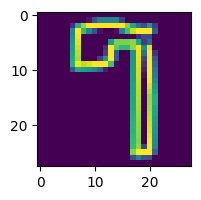

In [11]:
plt.figure(figsize=(2,2))
plt.imshow(et[5].reshape(28,28))

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
from torch import nn, optim
from torchvision import transforms, datasets

In [13]:
data_dirs = {
    'train': '/kaggle/working/train/',
    'valid': '/kaggle/working/valid/',
    'test': '/kaggle/working/test/',
}

In [14]:
files = items
idx_to_class = sorted([f.split('.')[0] for f in files])

class_to_idx = {idx_to_class[i]: i for i in range(len(idx_to_class))}

len(idx_to_class), class_to_idx, idx_to_class

(12,
 {'anvil': 0,
  'axe': 1,
  'backpack': 2,
  'bicycle': 3,
  'bridge': 4,
  'guitar': 5,
  'key': 6,
  'knife': 7,
  'ladder': 8,
  'parachute': 9,
  'stairs': 10,
  'sword': 11},
 ['anvil',
  'axe',
  'backpack',
  'bicycle',
  'bridge',
  'guitar',
  'key',
  'knife',
  'ladder',
  'parachute',
  'stairs',
  'sword'])

In [15]:
data_transforms = {
    'train':transforms.Compose([
            transforms.RandomRotation(10),
            transforms.ToTensor(),
#             transforms.Normalize([0.155], [0.316])
        ]),
    'valid':transforms.Compose([
            transforms.ToTensor(),
#             transforms.Normalize([0.155], [0.316])
        ]),
    'test':transforms.Compose([
            transforms.ToTensor(),
#             transforms.Normalize([0.155], [0.316])
        ])
}

In [16]:
dataset = {}
# mean, std = None, None

for d in ['train', 'valid', 'test']:
    data_x = []
    data_y = []
    for path, _, files in os.walk(data_dirs[d]):
        for f in files and items:
            c = f.split('.')[0] # get class name from file name
            x = np.load(path + f).reshape(-1, 28, 28) / 255
            y = np.ones((len(x), 1), dtype=np.int64) * class_to_idx[c]
            
            data_x.extend(x)
            data_y.extend(y)
#     if d == 'train':
#         mean = np.mean(data_x)
#         std = np.std(data_x)
    dataset[d] = torch.utils.data.TensorDataset(torch.stack([data_transforms[d](Image.fromarray(np.uint8(i*255))) for i in data_x]), 
                                                torch.stack([torch.Tensor(j) for j in data_y]))

In [17]:
[len(dataset[d]) for d in ['train', 'valid', 'test']]

[235200, 100800, 84000]

In [18]:
bs = 128 # batch size

In [19]:
dataloaders = {
    d: torch.utils.data.DataLoader(dataset[d], batch_size=bs, shuffle=True) for d in ['train', 
                                                                                      'valid', 
                                                                                      'test']
}

In [20]:
invTrans = transforms.Compose([ transforms.Normalize([0.],[1/0.316]),
                                transforms.Normalize([-0.155],[1.]),
                               ])

def imshow(img):
    plt.imshow(img.reshape(28,28), cmap='gray')

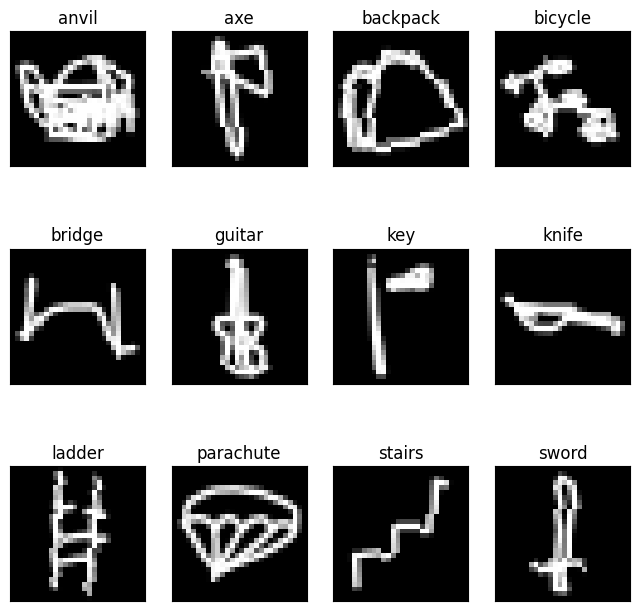

In [21]:
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

fig = plt.figure(figsize=(8, 8))
# display 9 images
for cls in np.arange(12):
    ax = fig.add_subplot(3, 4, cls+1, xticks=[], yticks=[])
    
    image = images.numpy()[labels.numpy().reshape(-1) == cls][0]
    label = labels.numpy()[labels.numpy().reshape(-1) == cls][0, 0].astype(np.int64)
    imshow(image)
    ax.set_title(idx_to_class[label])

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [23]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14x14x5
            nn.Conv2d(5, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 7x7x8
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU() # 7x7x16
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*16, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(100, 12)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out


model_scratch = Net()
model_scratch.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=12, bias=True)
  )
)

In [24]:
criterion_scratch = nn.CrossEntropyLoss()

# optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

In [25]:
def train(n_epochs, loaders, model, optimizer, criterion, device, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_losses = []
    val_losses = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU or CPU
#             print(torch.max(target,1)[0])
            data, target = data.to(device), target.long().to(device)
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss as follows
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, torch.max(target,1)[0])
            
            loss.backward()
            optimizer.step()
            
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU or CPU
            data, target = data.to(device), target.long().to(device)
            
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, torch.max(target,1)[0])
            
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        
        if valid_loss < valid_loss_min:
            print('Saving model..')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
    
    # return trained model
    return model, train_losses, val_losses

In [26]:
# train the model
model_scratch, train_losses, val_losses = train(40, dataloaders, model_scratch, optimizer_scratch,criterion_scratch, device, '/kaggle/working/model_scratch-40epochs_final.pt')

Epoch: 1 	Training Loss: 0.781751 	Validation Loss: 0.469113
Saving model..
Epoch: 2 	Training Loss: 0.514313 	Validation Loss: 0.391817
Saving model..
Epoch: 3 	Training Loss: 0.454262 	Validation Loss: 0.382412
Saving model..
Epoch: 4 	Training Loss: 0.421404 	Validation Loss: 0.361310
Saving model..
Epoch: 5 	Training Loss: 0.398976 	Validation Loss: 0.337066
Saving model..
Epoch: 6 	Training Loss: 0.380701 	Validation Loss: 0.325995
Saving model..
Epoch: 7 	Training Loss: 0.366239 	Validation Loss: 0.325341
Saving model..
Epoch: 8 	Training Loss: 0.353708 	Validation Loss: 0.319183
Saving model..
Epoch: 9 	Training Loss: 0.344196 	Validation Loss: 0.307949
Saving model..
Epoch: 10 	Training Loss: 0.335653 	Validation Loss: 0.307893
Saving model..
Epoch: 11 	Training Loss: 0.326935 	Validation Loss: 0.303465
Saving model..
Epoch: 12 	Training Loss: 0.322247 	Validation Loss: 0.300154
Saving model..
Epoch: 13 	Training Loss: 0.318136 	Validation Loss: 0.300195
Epoch: 14 	Training Los

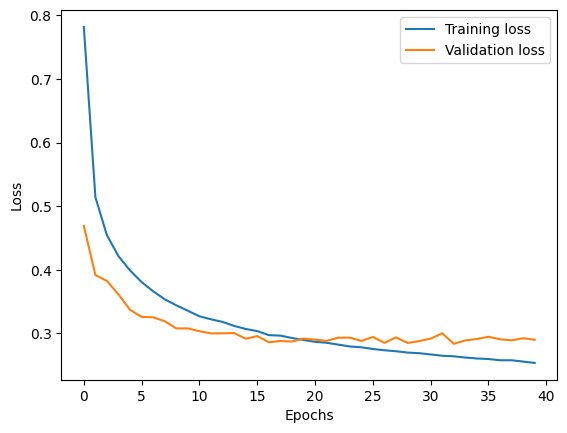

In [27]:
import matplotlib.pyplot as plt

# Convert the train and validation losses to NumPy arrays on the CPU
train_losses_np = [loss.cpu().numpy() for loss in train_losses]
val_losses_np = [loss.cpu().numpy() for loss in val_losses]

# Plot the training and validation loss curves
plt.plot(train_losses_np, label='Training loss')
plt.plot(val_losses_np, label='Validation loss')

# Set the x-axis ticks
plt.xticks([i for i in range(0, len(train_losses_np), 5)] + [len(train_losses_np)])

# Set labels and limits
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
_ = plt.ylim()

# Show the plot
plt.show()

In [28]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('/kaggle/working/model_scratch-40epochs_final.pt'))

<All keys matched successfully>

In [29]:
def mapk(target, output, k=3):
    map_sum = 0
    output = torch.topk(output, k)[1]
    for i, t in enumerate(target):
        idx = (output[i] == t).nonzero().cpu().numpy()
        if len(idx) == 0:
            continue
            
        idx = idx[0][0]
        map_sum += 1 / (idx + 1)
        
    return map_sum

In [30]:
def test(loaders, model, criterion, device):
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    total_mapk = 0
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU or CPU
        data, target = data.to(device), target.long().to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target.view(-1))
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
        
        total_mapk += mapk(target, output)
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    map3 = np.around(total_mapk / len(loaders["test"].dataset) * 100, 2)
    print(f'\nMean Average Precision @ 3: {map3}%')
          
    return y, y_hat

In [31]:
# call test function    
y, y_hat = test(dataloaders, model_scratch, criterion_scratch, device)

Test Loss: 0.280753


Test Accuracy: 91% (77256/84000)

Mean Average Precision @ 3: 94.31%


In [32]:
def accuracy(y, y_hat):
        """
        y [np array]: actual labels
        y_hat [np array]: predicted labels
        
        return: accuracy between 0 and 1
        """
        return np.sum(y == y_hat) / len(y)

In [33]:
accuracy(y, y_hat)

0.9197142857142857

In [34]:
def confusion_matrix(y, y_hat, nclasses):
        """
        y [np array]: actual labels [values between 0 to nclasses-1]
        y_hat [np array]: predicted labels [values between 0 to nclasses-1]
        nclasses [integer]: number of classes in the dataset.
        
        return: confusion matrix of shape [nclasses, nclasses]
        """
        y = y.astype(np.int64)
        y_hat = y_hat.astype(np.int64)

        conf_mat = np.zeros((nclasses, nclasses))

        for i in range(y_hat.shape[0]):
            true, pred = y[i], y_hat[i]
            conf_mat[true, pred] += 1

        return conf_mat

In [35]:
cm = confusion_matrix(y, y_hat, nclasses=len(idx_to_class))

In [36]:
import itertools

In [37]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7)):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

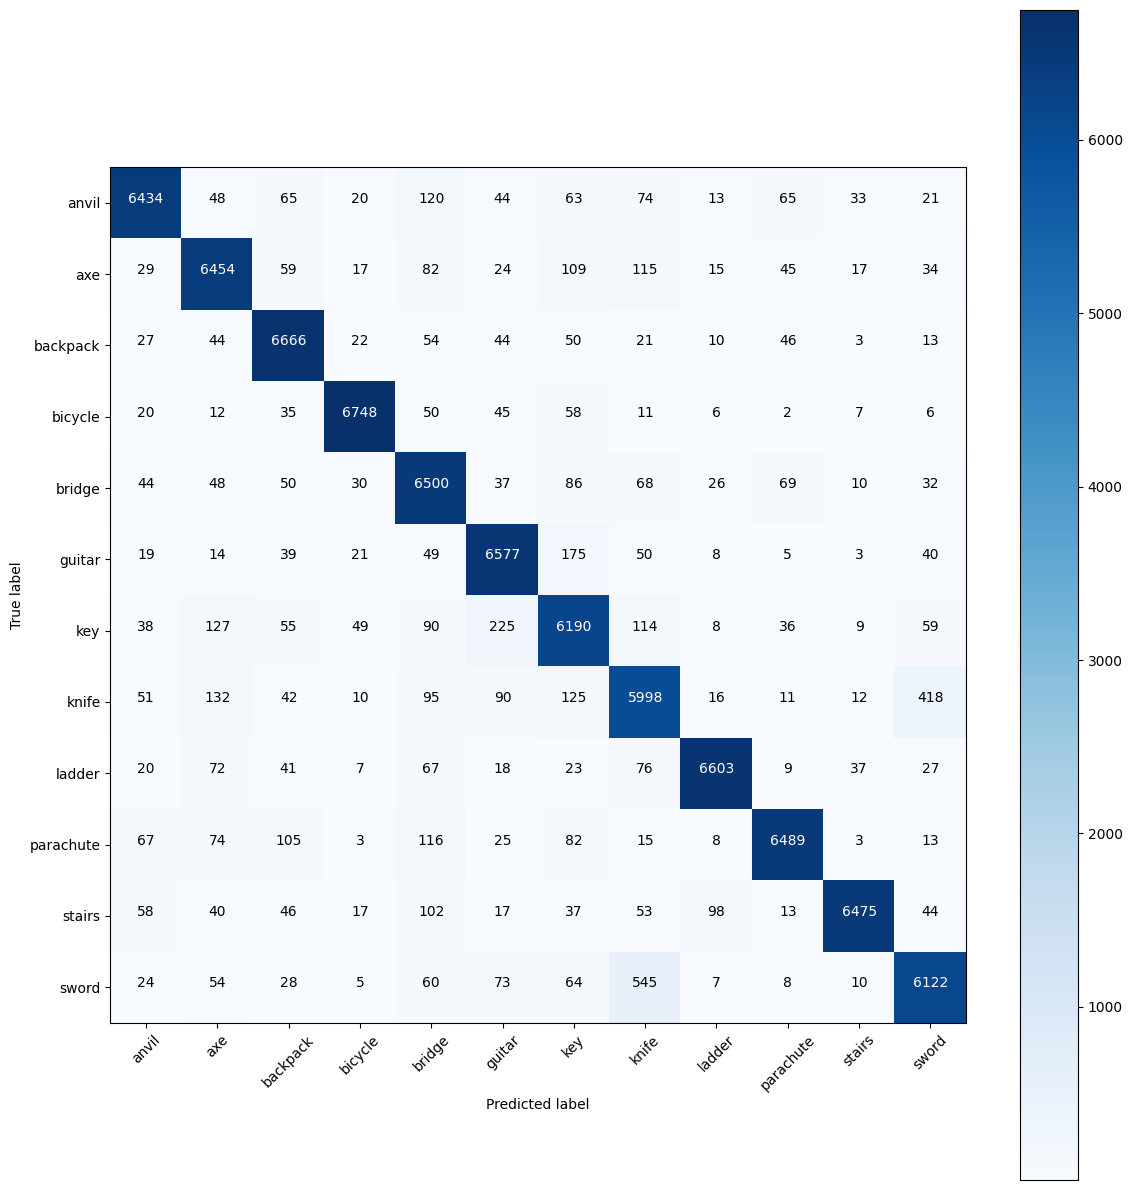

In [38]:
plot_confusion_matrix(cm, idx_to_class, title='', figsize=(12,12))